<a href="https://colab.research.google.com/github/bhagirathtallapragada/T-Natural-Language-Processing-CSC8980/blob/main/exam2/nlpexam2fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bhagirath Tallapragada panther id: 002575358

Question 1) (20 points) Write a function that takes a List of five words: [‘apple’, ‘house’, ‘pear’,
‘dog’, ‘doctor’] and returns a list of lists with each element being a word and a list of the top five
most similar words. For this task you have to use the most suitable method of the ones we have
seen in class to determine the most similar words to the original input list. You can use a
pre-trained resource if you think is appropriate. After calling your function, print the most similar
words to the screen. Are these ‘similar’ words actually similar? If not, why not? What do you
think can be improved and how - talk about it, do not necessarily implement it?


Using Google's Word2Vec pre-computed embeddings from https://code.google.com/archive/p/word2vec/ for this question:

In [ ]:
!gdown --id 0B7XkCwpI5KDYNlNUTTlSS21pQmM

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:09, 167MB/s]


In [ ]:
!gunzip /content/GoogleNews-vectors-negative300.bin.gz 

In [ ]:
from gensim.models import KeyedVectors
filename = '/content/GoogleNews-vectors-negative300.bin'
model = KeyedVectors.load_word2vec_format(filename, binary=True)

In [ ]:
keywords=['apple', 'house', 'pear', 'dog', 'doctor']

In [ ]:
def most_similar(l):
  res=[]
  for i in l:
    # dat=[]
    dat=[tup[0] for tup in model.most_similar(i)]
    dat=dat[:5]
    res.append(dat)
  return res

In [ ]:
res=most_similar(keywords)
print("keywords:\n {}".format(keywords))
print("similar words list\n {}".format(res))

keywords:
 ['apple', 'house', 'pear', 'dog', 'doctor']
similar words list
 [['apples', 'pear', 'fruit', 'berry', 'pears'], ['houses', 'bungalow', 'apartment', 'bedroom', 'townhouse'], ['pears', 'apricot', 'apricots', 'nectarine', 'Fuji_apple'], ['dogs', 'puppy', 'pit_bull', 'pooch', 'cat'], ['physician', 'doctors', 'gynecologist', 'surgeon', 'dentist']]


Observation: As can be observed the similar words fetched by the function for most of the keywords is a mixed bag of great and poor similarity. For instance the words like  'fruit, 'berry' are accurately similar to the keyword 'apple' (meaning a fruit). However, the model does misfire in terms of differentiating between different forms of the same word such as plurality. This results in capture of the *same word* being branded as a *similar* word.
In terms of improving this, a threshold could be introduced to filter out words that are too similar to each other. For instance, the word vector of 'house' will be nearly similar to 'houses', where as other similar words such as 'bungalow' or 'apartment' will still be relatively different.  

Question 2) (30 points) Using the Homework 2 dataset, also attached in the Exam 2 files,
shakespeares-works_TXT_FolgerShakespeare.zip. Find the document to document similarity
using:
a) Cosine similarity. And create a 42 x 42 heatmap of these similarities.
b) Use Doc2Vec to create document embeddings and find the similarities between the
documents. To visualize this, also create a 42 x 42 heatmap for this.
c) What are the differences you find between the two methods? Is there anything radically
different? Please describe your answer in terms of the heatmap of part a and part b.

In [1]:
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import bigrams, trigrams
from collections import Counter, defaultdict

import pandas as pd
import numpy as np
import os
import gensim

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/shakespeares-works_TXT_FolgerShakespeare.zip -d /content/drive/MyDrive/

In [3]:
directory='/content/drive/MyDrive/shakespeares-works_TXT_FolgerShakespeare'
collection=[]
doc_name=[]
for filename in os.listdir(directory):
  if (filename.endswith('.txt')):
    string1=(open(os.path.join(directory, filename)))
    collection.append(string1.read())

    doc_name.append(filename.rstrip('.txt'))

a. Using Cosine Similarity:

In [12]:
def cosine_sim_creator(collection):
  tfIdfVectorizer1=TfidfVectorizer()
  tfIdf = tfIdfVectorizer1.fit_transform(collection)
  # tfIdf=tfIdf.astype(np.float32)
  csmat=cosine_similarity(tfIdf)

  return csmat

In [13]:
cs=cosine_sim_creator(collection)
cs

array([[1.        , 0.63130422, 0.56777768, ..., 0.62809744, 0.58210527,
        0.70198325],
       [0.63130422, 1.        , 0.53550819, ..., 0.59404353, 0.53697935,
        0.70306567],
       [0.56777768, 0.53550819, 1.        , ..., 0.52581905, 0.47821321,
        0.60407163],
       ...,
       [0.62809744, 0.59404353, 0.52581905, ..., 1.        , 0.52841954,
        0.67101444],
       [0.58210527, 0.53697935, 0.47821321, ..., 0.52841954, 1.        ,
        0.58303526],
       [0.70198325, 0.70306567, 0.60407163, ..., 0.67101444, 0.58303526,
        1.        ]])

In [14]:
cs.shape

(42, 42)

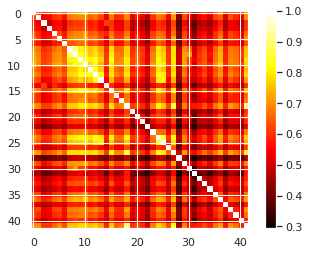

In [50]:
plt.imshow(cs, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

b. Using Doc2Vec:

In [40]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(collection)]
model = Doc2Vec(documents)

In [41]:
X = []
for i in range(len(collection)):
  X.append(model.infer_vector(collection[i]))

In [43]:
len(X)

42

In [46]:
cs2=cosine_similarity(X)
cs2

array([[ 1.0000001 ,  0.23162475, -0.12114841, ..., -0.18891105,
         0.27973443,  0.35160038],
       [ 0.23162475,  1.0000001 , -0.1021529 , ..., -0.13561012,
         0.22396421,  0.15577094],
       [-0.12114841, -0.1021529 ,  1.        , ...,  0.30140823,
         0.23245032,  0.15710765],
       ...,
       [-0.18891105, -0.13561012,  0.30140823, ...,  1.0000001 ,
        -0.42639315,  0.37269056],
       [ 0.27973443,  0.22396421,  0.23245032, ..., -0.42639315,
         1.        ,  0.11739547],
       [ 0.35160038,  0.15577094,  0.15710765, ...,  0.37269056,
         0.11739547,  0.9999999 ]], dtype=float32)

In [48]:
cs2.shape

(42, 42)

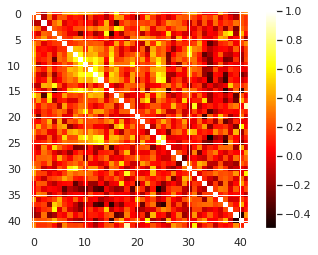

In [49]:
plt.imshow(cs2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

c. What are the differences you find between the two methods? Is there anything radically
different? Please describe your answer in terms of the heatmap of part a and part b

In terms of the two generated heatmaps, the most visible difference is that the Doc2Vec model has lesser number of black cells than the cosine similarity method. This indicates that the doc2vec model seems to find more similarity in the documents as compared to the cosine similarity.
Both models seem to agree about the most similar documents in the way the yellow color band is spread, however both tell a different story in terms of non similar documents. The non similar documents are sparse in in the doc2vec model where as they are clearly distinguishable and linear in cosine similarity criscrossing the heatmap. 

Question 3) (30 points) Using the Homework 2 dataset. Use SpaCy to extract the following:


a) Write a function to generate all unique bigrams from all documents in the dataset. The
input of this function should be the concatenated dataset and the output should be the
list of bigrams and their frequency. Display the top 10 most common bigrams and their
frequency.

In [4]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [5]:
def n_common_freq_bi(collection):
  bi_model = defaultdict(lambda: defaultdict(lambda: 0))
  sentences= []
  for i in collection:
    sentences.append(nltk.word_tokenize(i.rstrip('\n')))
  bigram=[]
  for i in sentences:
    bigram.extend(list(nltk.bigrams(i)))
    # compute frequency of bigrams
  d={}
  for x in bigram:
    d[x] = d.get(x,0) + 1
  bigram=set(bigram)
  bi_freq={}
  for i in bigram:
    bi_freq[i]=d[i]
  sorted_freq = sorted(bi_freq.items(), key=lambda x: x[1], reverse=True)
  return sorted_freq

In [6]:
res=n_common_freq_bi(collection)
#printing 10 most common bigrams
for i in res[:10]:
  print([i[0],i[1]])

[(',', 'and'), 7555]
[('.', ']'), 6766]
[('.', '['), 4857]
[(',', 'I'), 4460]
[(',', 'And'), 3742]
[('.', 'I'), 3132]
[(',', '['), 2773]
[(',', 'my'), 2251]
[('[', 'Enter'), 2177]
[('I', 'am'), 1962]


b) Write a function to generate all unique trigrams from all documents in the dataset. The
input of this function should be the concatenated dataset and the output should be the
list of trigrams and their frequency. Display the top 10 most common trigrams and their
frequency.

In [7]:
# defining the function to return the 10 most common bigrams with their frequencies

def n_common_freq_tri(collection):
  tri_model = defaultdict(lambda: defaultdict(lambda: 0))
  sentences= []
  for i in collection:
    sentences.append(nltk.word_tokenize(i.rstrip('\n')))
  trigram=[]
  for i in sentences:
    trigram.extend(list(nltk.trigrams(i)))
    # compute frequency of trigrams
  d={}
  for x in trigram:
    d[x] = d.get(x,0) + 1
  trigram=set(trigram)
  tri_freq={}
  for i in trigram:
    tri_freq[i]=d[i]
  sorted_freq = sorted(tri_freq.items(), key=lambda x: x[1], reverse=True)
  return sorted_freq

In [8]:
res=n_common_freq_tri(collection)
#printing 10 most common trigrams
for i in res[:10]:
  print([i[0],i[1]])

[('.', '[', 'Enter'), 994]
[(',', 'sir', ','), 991]
[('exits', '.', ']'), 986]
[('exit', '.', ']'), 970]
[(',', 'my', 'lord'), 957]
[('.', '[', 'He'), 918]
[(',', '[', 'to'), 876]
[(',', '[', 'as'), 717]
[('.', '[', 'They'), 698]
[('=======', '[', 'Enter'), 630]


c) Write a function to extract all unique NOUN and VERB tokens. The input of this function
should be the concatenated dataset and the output should be two lists: one of the NOUN
tokens and their frequency, the other list should be the VERB tokens and their counts.
Display the top 10 most common NOUN and VERB tokens.

In [221]:
import collections
from nltk.tokenize import sent_tokenize

In [218]:
#concatinate the collection
col=" ".join(collection)
# col1="HELEN O, my good lord, when I was like this maid, I found you wondrous kind. There is your ring, And, look you, here's your letter. [She takes out a paper.] This it says: When from my finger you can get this ring And are by me with child, etc. This is done. Will you be mine now you are doubly won?"

In [256]:
def ext_nv(col):
  nouns=[]
  verbs=[]
  # col=col.splitlines()
  # print(col)
  # doc=nlp(col)
  for text in col.splitlines():
    doc=nlp(text)
    for token in doc:
      if token.pos_ =="NOUN":
        nouns.append(str(token))
      elif token.pos_ =="VERB":
        verbs.append(str(token))
  noun_count=Counter(nouns)
  verb_count=Counter(verbs)
  return list(noun_count.items()), list(verb_count.items())

In [257]:
sorted_noun_freq, sorted_verb_freq=ext_nv(col)

In [262]:
#printing the 10 most common nouns and verbs

print(sorted(sorted_noun_freq, key = lambda x: x[1], reverse=True)[:10])
print(sorted(sorted_verb_freq, key = lambda x: x[1], reverse=True)[:10])

[('man', 1969), ('love', 1573), ('sir', 1280), ('heart', 1099), ('time', 1074), ('father', 992), ('men', 970), ('life', 933), ('hand', 925), ('death', 877)]
[('will', 4445), ('shall', 3349), ("'ll", 2598), ('would', 2166), ('can', 1901), ('Enter', 1759), ('know', 1680), ('make', 1575), ('come', 1568), ('may', 1546)]


d) What do you think the most common bigrams and trigrams could be useful for? There is
a particular method we have seen in this class to characterize a corpus that could benefit
from having these bigrams/trigrams when the underlying text corpus can’t be shared.
Please talk about this.

Ans.Bigrams and Trigrams can be useful for tasks such as text completion. It can be very helpful to approximate the most probable word pairs for a particular meaning. For example: 'childish view' vs 'childlike viiew' . Though similar in occurance the former can have alternate meanings. So frequent bigrams or trigrams can be analysed to obtain regular and politically correct representation of text. This ability extends to another area of study which is to analyse the change in language patterns over periodic intervals. word Pairings can be studied to see how some word expressions change over time without technically altering the intended meaning. 

Question 4) (30 points) Using the dataset: Ask0729, found in Exam files, write two functions to
extract all dates found in this dataset. The input of these functions should take the dataset as
input, and output a list of dates. You should use two different methods, one per function.
a) First method: using SpaCy (this is a big enough hint)
b) Second method: using regular expressions.
c) Print to screen to compare the results from the two functions.
d) Which one of the two approaches was better? Why do you think so? Would you use any
of these approaches? Or a different one?

In [ ]:
!unzip /content/sample_data/Ask0729.zip -d /content/sample_data/

Archive:  /content/sample_data/Ask0729.zip
  inflating: /content/sample_data/Ask0729-fixed.txt  


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
directory='/content/sample_data/'
collection=[]
for filename in os.listdir(directory):
  if (filename=='Ask0729-fixed.txt'):
    string1=(open(os.path.join(directory, filename)))
    collection.append(string1.read())

    # doc_name.append(filename.rstrip('.txt'))

In [ ]:
collection[:10]

['No\t>>> [1]Contact Me Now to Make $100 Today!$LINK\nNo\tAct now to keep your life on the go!\nNo\tChoose between $500 and $10000 dollars with up to 5 years to repay!\nNo\tClick above to earn today.\nNo\tClick here to receive your first $10 today:\nNo\tClick here to start shopping now: $LINK\nNo\tClick here to watch this now, I\'m not sure how long he\'ll leave this up in public:*ï¿½\nNo\tConfirm now and view your first great opportunity\nNo\tCopy and paste this link into your browser to see your results now.\nNo\tFind out how to add clippings to your pressroom in this 125 seconds video\nNo\tGo Here Now For Direct Access\nNo\tGo Here Now For More Information\nNo\tIf you do not have Adobe Acrobat Reader, please click below and follow instructions for free download: http://tr.innovyx.com/redir.asp?148_46_2788\nNo\tIf you do not want to confirm, simply ignore this message.\nNo\tIf you don\'t want to change your password, just ignore this message.\nNo\tIf you see nothing or a banner below

In [ ]:
# using regexp
import re
col=" ".join(collection)

def regex_dates(col):
  dates_reg=re.findall(r"(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec\w*)\s[\d]{4} | [\d]{1,2} [ADFJMNOS]\w* [\d]{4}", col, re.I)
  return dates_reg

In [ ]:
# using spacy

def spacy_dates(collection):
  dates_sp=[]
  for i in collection:
    doc=nlp(i)
    for ent in doc.ents:
      if ent.label_=='DATE':
        # print(ent.text, ent.label_)
        dates_sp.append(ent.text)
  return dates_sp

c. Print to screen to compare the results from the two functions.

In [ ]:
dates_re=regex_dates(col)
print(dates_re)

[' 30 June 2012', ' 28 August 2011', ' 1 Dec 2013', ' 29 April 2012']


In [ ]:
dates_sp=spacy_dates(collection)
print(dates_sp)
print(len())

['up to 5 years', 'today', 'today', 'today', 'one week', 'MA 02143', 'daily', 'today', '3+ Nights & Save', 'this week', 'weekend', 'this week', '2 Weeks', 'the year', 'tomorrow', 'Wednesday', 'Saturday', 'the 6 year old', 'tomorrow', '25 years', 'year end 2000', 'under 40/over 40', 'junior-year', 'all summer', 'next week', 'yesterday', 'Monday', 'Thursday 4:00PM', 'July 31, 2014', '30 June 2012', 'April 15th', 'this year', 'this time', 'next year', 'years', 'Friday', 'Monday', 'December 7th', 'yesterday', 'yesterday', 'tomorrow', '14 day', '2 days', 'years', 'tomorrow', 'tomorrow', 'tomorrow', 'the next year', 'Sunday', 'a day', '12 MONTHS', 'July 4, 2012', 'Tomorrow', 'this week', 'Tuesday, March 20, 2001', 'annual', '21st Century', 'this week', 'tomorrow', 'next Wednesday', 'the old days', 'Next week', 'April', 'the 19th', 'August 31st', 'the year', 'only a week', 'June 23, 2000', 'today', 'Last week', 'Friday', 'the week', 'the 31st of March', '1 Year Giveaway', 'Thanksgiving', 'Tod

d) Which one of the two approaches was better? Why do you think so? Would you use any of these approaches? Or a different one?

Based on the results above I feel using the Spacy approach does a better job at identifying every single possibility of date entity. On the other hand the regex method has its own merits in terms of identifying precise formats of date. It offers superior control over handling noise unlike the Spacy method which returns just about anything resembling a datetime entity. This advantage of regex comes with a pinch of salt too as it requires manual analysis of the dataset first to identify different formats or styles in which a date string can exist. This makes it prone to missing some edge cases that may escape the eye. I find it open to interpretation as to which approach is better as it depends on how specific the format of the extracted dates should be. 
In terms of applicability a wiser method in my opinion is to combine usage of both where first we let the spacy identify the date entity in the dataset and return a list. Then we can extract specific patterns from this list based on requirement using regular expressions. 

5. Train an LSTM model to classify the Cornell Movie Review data
using the polarity_dataset V2.0. You can use the code for class 19, but take a note that
you will have to adapt some of the parameters like: Review size = 450, epochs=5. You will use
85% of the dataset for training, and 15% for testing. Once you build the model, please display
the sklearn classification report. What are you noticing here? Anything unexpected? How does
this model compare to the one built with the IMDB dataset in class? Any ideas on how to
improve it?

In [ ]:
# All the imports!
import tensorflow as tf 
import numpy as np
from tensorflow.keras.preprocessing import sequence
import os
from numpy import array
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# Supress deprecation warnings
import logging
logging.getLogger('tensorflow').disabled = True
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# tar –xvzf /content/drive/MyDrive/review_polarity.tar
# %%bash
# !tar –xvf /content/drive/MyDrive/review_polarity.tar.gz #–C '/home/user/destination'

In [ ]:
directory='/content/drive/MyDrive/review_polarity/txt_sentoken'
collection=[]
doc_name=[]
label=[]
for dir in os.listdir(directory):
  print(dir)
  if (dir == "neg"):
    dir1=directory+'/neg/'
    print(dir1)
    for filename in os.listdir(dir1):
      if (filename.endswith('.txt')):
        string1=(open(os.path.join(dir1, filename)))
        collection.append(string1.read())
        doc_name.append(filename.rstrip('.txt'))
        label.append(0)
  elif (dir == "pos"):
    dir1=directory+'/pos/'
    print(dir1)
    for filename in os.listdir(dir1):
      if (filename.endswith('.txt')):
        string1=(open(os.path.join(dir1, filename)))
        collection.append(string1.read())
        doc_name.append(filename.rstrip('.txt'))
        label.append(1)

neg
/content/drive/MyDrive/review_polarity/txt_sentoken/neg/
pos
/content/drive/MyDrive/review_polarity/txt_sentoken/pos/


In [ ]:
data_set=pd.DataFrame(list(zip(doc_name, collection, label)), columns =['doc_name', 'text', 'label'])

In [ ]:
data_set.head()

,doc_name,text,label
0,cv000_29416,"plot : two teen couples go to a church party ,...",0
1,cv001_19502,the happy bastard's quick movie review \ndamn ...,0
2,cv002_17424,it is movies like these that make a jaded movi...,0
3,cv003_12683,""" quest for camelot "" is warner bros . ' firs...",0
4,cv004_12641,synopsis : a mentally unstable man undergoing ...,0


In [ ]:
train_a, test_a = train_test_split(data_set, test_size=0.15, random_state=12345)

In [ ]:
X=list(train_a['text'].values)

In [ ]:
from keras.preprocessing.text import Tokenizer
enc=[]
tokenizer=Tokenizer(filters='')
tokenizer.fit_on_texts(X)

enc=tokenizer.texts_to_sequences(X)

In [ ]:
print(enc[60])

[142, 197, 1, 1369, 3057, 1, 708, 45, 861, 52, 4938, 142, 969, 52, 222, 2856, 1, 4683, 17266, 1, 5, 4, 848, 6, 1833, 142, 519, 27, 567, 17267, 5, 436, 27, 1690, 29004, 142, 17268, 52, 2610, 29005, 13, 222, 2856, 12, 680, 18, 129, 337, 19, 17269, 92, 493, 5486, 9, 1156, 1033, 272, 2, 6720, 6, 2, 6708, 7260, 2338, 3, 116, 1855, 7, 6363, 22, 2, 2376, 443, 27, 2793, 28, 955, 17, 2, 379, 3, 345, 94, 72, 6, 2, 695, 140, 2, 837, 6, 602, 1833, 5, 118, 111, 8796, 85, 3, 21338, 5, 644, 522, 52, 29, 101, 1281, 7614, 3, 21, 5565, 6, 197, 5, 1036, 17270, 1580, 3, 2156, 133, 1560, 20, 19, 397, 1, 5, 1652, 1, 9, 366, 426, 2, 1422, 6, 424, 251, 17, 4, 622, 3, 21, 2533, 6, 2, 19, 91, 5837, 45, 1054, 28, 805, 71, 3, 21, 335, 6, 41, 2, 8208, 23, 212, 22, 2, 937, 1, 597, 222, 2856, 16, 2, 7683, 1052, 3, 321, 29, 76, 875, 1254, 20, 19, 7, 370, 341, 17, 4, 764, 8209, 1, 286, 245, 95, 7, 948, 4, 356, 6, 605, 3, 29006, 1, 48, 3302, 522, 52, 29007, 6, 29008, 21, 2517, 328, 29, 1281, 20, 19, 34, 1, 11, 141, 125

In [ ]:
#setting the max_review_len to 450
max_review_len=450
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
X= sequence.pad_sequences(enc, maxlen=max_review_len)

In [ ]:
X[60].shape

(450,)

In [ ]:
train_a.insert(3,"encoded_list", X.tolist())

In [ ]:
# designing the LSTM model
model = tf.keras.models.Sequential()
model.add(
    tf.keras.layers.Embedding(
        input_dim = vocab_size, # The size of our vocabulary 
        output_dim = 32, # Dimensions to which each words shall be mapped
        input_length = max_review_len # Length of input sequences
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.LSTM(
        units=32 # 32 LSTM units in this layer
    )
)

model.add(
    tf.keras.layers.Dropout(
        rate=0.25 # Randomly disable 25% of neurons
    )
)

model.add(
    tf.keras.layers.Dense(
        units=1, # Single unit
        activation='sigmoid' # Sigmoid activation function (output from 0 to 1)
    )
)

model.compile(
    loss=tf.keras.losses.binary_crossentropy, # loss function
    optimizer=tf.keras.optimizers.Adam(), # optimiser function
    metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 450, 32)           1660480   
_________________________________________________________________
dropout (Dropout)            (None, 450, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,668,833
Trainable params: 1,668,833
Non-trainable params: 0
_________________________________________________________________


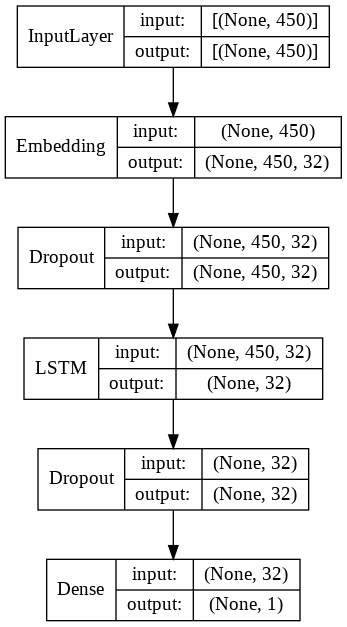

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [ ]:
y=train_a['label'].values
print(len(y))
print(y[:5])

1700
[1 0 1 1 1]


In [ ]:
history = model.fit(
    x=X, y=y,
    batch_size=100, 
    epochs=5, 
    validation_split=0.2,
    verbose=1
)

Epoch 1/5
14/14 [==============================] - 6s 300ms/step - loss: 0.6930 - accuracy: 0.5040 - val_loss: 0.6919 - val_accuracy: 0.5618
Epoch 2/5
14/14 [==============================] - 4s 283ms/step - loss: 0.6887 - accuracy: 0.6354 - val_loss: 0.6875 - val_accuracy: 0.5265
Epoch 3/5
14/14 [==============================] - 4s 276ms/step - loss: 0.6620 - accuracy: 0.5978 - val_loss: 0.6642 - val_accuracy: 0.6265
Epoch 4/5
14/14 [==============================] - 4s 273ms/step - loss: 0.6310 - accuracy: 0.7938 - val_loss: 0.6272 - val_accuracy: 0.6059
Epoch 5/5
14/14 [==============================] - 4s 268ms/step - loss: 0.4507 - accuracy: 0.8597 - val_loss: 0.5904 - val_accuracy: 0.7559


In [ ]:
# getting the test data

y_=list(test_a['text'].values)
enc_2 = tokenizer.texts_to_sequences(y_)
enc_2 = sequence.pad_sequences(enc_2, maxlen=max_review_len)

yt=test_a['label'].values

In [ ]:
from sklearn.metrics import classification_report
class_names = ["Negative", "Positive"]
predicted_classes = model.predict_classes(enc_2)
print(classification_report(yt, predicted_classes, target_names=class_names))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

    Negative       0.75      0.69      0.72       164
    Positive       0.66      0.73      0.69       136

    accuracy                           0.71       300
   macro avg       0.71      0.71      0.71       300
weighted avg       0.71      0.71      0.71       300



Observation:

The model performs better than the the multinomial naive bayes and randomforest classifiers built in class. However it surprisingly fails to beat SVM model trained in class in terms of accuracy, precision and recall. It goes to say that the LSTM model is affected by the small size of the training dataset. While the SVM model performs well with the given size. 
One suggestion to improve this model is to have greater size of training data. Secondly, the truncation of review sizes to 450 could also be a factor as important context can be lost in the process. Therefore by testing the model to work with the maximum size of the review lengths we could expect some improvement.

Question 6) (30 points) Use the train.txt file from the PubMed 20K RCT dataset fine-tune a
BERT transformer (class 9 code). This task is a bit different as the one seen in class, here the
source dataset has FIVE different classes: background, objective, method, result, and
conclusion. Once the BERT model is fine-tuned, classify the: test.txt set. Please present the
per-class classification report (accuracy, precision, recall, f1-score metrics). Also, present the
global metrics - all classes (accuracy, precision, recall, f1-score metrics). Did you model beat the
baseline results (https://arxiv.org/pdf/1710.06071.pdf)? What do you think you can do to improve
it?


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PubMed_20K_RCT/train.csv", delimiter='\t',header=None, names=['classes','text'])

In [ ]:
df

,classes,text
0,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...
1,METHODS,A total of 125 patients with primary knee OA w...
2,METHODS,Outcome measures included pain reduction and i...
3,METHODS,Pain was assessed using the visual analog pain...
4,METHODS,Secondary outcome measures included the Wester...
...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...
180036,RESULTS,"For PAV , a significantly greater percentage o..."
180037,RESULTS,Both strategies had acceptable side effect pro...
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th..."


In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

Number of training sentences: 180,040



In [ ]:
label=[]
for i in df.classes:
  if i=="BACKGROUND":
    label.append(0)
  elif i=="OBJECTIVE":
    label.append(1)
  elif i=="METHODS":
    label.append(2)
  elif i=="RESULTS":
    label.append(3)
  elif i=="CONCLUSIONS":
    label.append(4)

In [ ]:
print(label)

[1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 0, 0, 0, 2, 2, 2, 3, 3, 3, 4, 1, 0, 2, 3, 3, 3, 3, 3, 3, 4, 4, 1, 2, 2, 2, 2, 2, 3, 3, 4, 0, 0, 0, 2, 3, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 4, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 4, 0, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 0, 0, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 0, 0, 0, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 3, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 4, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 

In [ ]:
df.insert(2, 'label', label)

In [ ]:
df

,classes,text,label
0,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...,1
1,METHODS,A total of 125 patients with primary knee OA w...,2
2,METHODS,Outcome measures included pain reduction and i...,2
3,METHODS,Pain was assessed using the visual analog pain...,2
4,METHODS,Secondary outcome measures included the Wester...,2
...,...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...,3
180036,RESULTS,"For PAV , a significantly greater percentage o...",3
180037,RESULTS,Both strategies had acceptable side effect pro...,3
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th...",4


In [ ]:
sentences = df.text.values
labels = df.label.values

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
Tokenized:  ['to', 'investigate', 'the', 'efficacy', 'of', '6', 'weeks', 'of', 'daily', 'low', '-', 'dose', 'oral', 'pre', '##d', '##nis', '##olo', '##ne', 'in', 'improving', 'pain', ',', 'mobility', ',', 'and', 'systemic', 'low', '-', 'grade', 'inflammation', 'in', 'the', 'short', 'term', 'and', 'whether', 'the', 'effect', 'would', 'be', 'sustained', 'at', '12', 'weeks', 'in', 'older', 'adults', 'with', 'moderate', 'to', 'severe', 'knee', 'os', '##te', '##oa', '##rth', '##rit', '##is', '(', 'o', '##a', ')', '.']
Token IDs:  [2000, 8556, 1996, 21150, 1997, 1020, 3134, 1997, 3679, 2659, 1011, 13004, 8700, 3653, 2094, 8977, 12898, 2638, 1999, 9229, 3255, 1010, 12969, 1010, 1998, 22575, 2659, 1011, 

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
Token IDs: tensor([  101,  2000,  8556,  1996, 21150,  1997,  1020,  3134,  1997,  3679,
         2659,  1011, 13004,  8700,  3653,  2094,  8977, 12898,  2638,  1999,
         9229,  3255,  1010, 12969,  1010,  1998, 22575,  2659,  1011,  3694,
        21733,  1999,  1996,  2460,  2744,  1998,  3251,  1996,  3466,  2052,
         2022,  8760,  2012,  2260,  3134,  1999,  3080,  6001,  2007,  8777,
         2000,  5729,  6181,  9808,  2618, 10441, 15265, 14778,  2483,  1006,
         1051,  2050,  1007,   102])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(12345))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

162,036 training samples
18,004 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 12345

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  5,064.    Elapsed: 0:00:14.
  Batch    80  of  5,064.    Elapsed: 0:00:29.
  Batch   120  of  5,064.    Elapsed: 0:00:44.
  Batch   160  of  5,064.    Elapsed: 0:01:00.
  Batch   200  of  5,064.    Elapsed: 0:01:15.
  Batch   240  of  5,064.    Elapsed: 0:01:30.
  Batch   280  of  5,064.    Elapsed: 0:01:45.
  Batch   320  of  5,064.    Elapsed: 0:02:00.
  Batch   360  of  5,064.    Elapsed: 0:02:15.
  Batch   400  of  5,064.    Elapsed: 0:02:30.
  Batch   440  of  5,064.    Elapsed: 0:02:45.
  Batch   480  of  5,064.    Elapsed: 0:03:00.
  Batch   520  of  5,064.    Elapsed: 0:03:15.
  Batch   560  of  5,064.    Elapsed: 0:03:31.
  Batch   600  of  5,064.    Elapsed: 0:03:46.
  Batch   640  of  5,064.    Elapsed: 0:04:01.
  Batch   680  of  5,064.    Elapsed: 0:04:16.
  Batch   720  of  5,064.    Elapsed: 0:04:31.
  Batch   760  of  5,064.    Elapsed: 0:04:46.
  Batch   800  of  5,064.    Elapsed: 0:05:01.
  Batch   840  of

In [ ]:
testdf = pd.read_csv("/content/drive/MyDrive/PubMed_20K_RCT/test.csv", delimiter='\t',header=None, names=['classes','text'])

In [ ]:
label=[]
for i in testdf.classes:
  if i=="BACKGROUND":
    label.append(0)
  elif i=="OBJECTIVE":
    label.append(1)
  elif i=="METHODS":
    label.append(2)
  elif i=="RESULTS":
    label.append(3)
  elif i=="CONCLUSIONS":
    label.append(4)

In [ ]:
print(label)

[0, 3, 3, 3, 3, 3, 3, 4, 4, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 0, 2, 2, 2, 3, 3, 3, 3, 4, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 0, 0, 2, 3, 3, 3, 4, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 0, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 0, 1, 2, 2, 2, 2, 3, 3, 3, 4, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 3, 3, 3, 4, 4, 0, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 4, 1, 1, 2, 2, 2, 2, 0, 3, 3, 3, 3, 3, 3, 4, 4, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 4, 0, 0, 1, 2, 2, 2, 3, 3, 3, 4, 4, 0, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 0, 0, 2, 2, 2, 2, 3, 3, 3, 3, 4, 0, 0, 0, 3, 3, 3, 3, 3, 3, 4, 4, 4, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 0, 0, 2, 3, 3, 3, 3, 4, 0, 0, 2, 2, 

In [ ]:
testdf.insert(2, 'label', label)

In [ ]:
testdf

,classes,text,label
0,BACKGROUND,This study analyzed liver function abnormaliti...,0
1,RESULTS,A post hoc analysis was conducted with the use...,3
2,RESULTS,Liver function tests ( LFTs ) were measured at...,3
3,RESULTS,Survival analyses were used to assess the asso...,3
4,RESULTS,The percentage of patients with abnormal LFTs ...,3
...,...,...,...
30130,RESULTS,There was a statistically significant between-...,3
30131,RESULTS,There were no statistically significant betwee...,3
30132,RESULTS,There was no significant association between s...,3
30133,RESULTS,No adverse effects were reported .,3


In [ ]:
sentences = testdf.text.values
labels = testdf.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 30,135 test sentences...
    DONE.


In [ ]:
from sklearn.metrics import classification_report
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)
class_names = ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]

tcr = classification_report(flat_true_labels, flat_predictions, target_names=class_names)

print('Per class classification report:\n {}'.format(tcr))

Per class classification report:
               precision    recall  f1-score   support

  BACKGROUND       0.68      0.82      0.74      3621
   OBJECTIVE       0.77      0.56      0.65      2333
     METHODS       0.93      0.95      0.94      9897
     RESULTS       0.92      0.91      0.92      9713
 CONCLUSIONS       0.85      0.81      0.83      4571

    accuracy                           0.87     30135
   macro avg       0.83      0.81      0.82     30135
weighted avg       0.87      0.87      0.87     30135



In [ ]:
# global metrics
import sklearn

print('*** Global Evaluation of BERT model ***')
print('Accuracy:', sklearn.metrics.accuracy_score(flat_true_labels, flat_predictions))
print('Precision:', sklearn.metrics.precision_score(flat_true_labels, flat_predictions, average='macro'))
print('Recall:', sklearn.metrics.recall_score(flat_true_labels, flat_predictions, average='macro'))
print('F1 Score:', sklearn.metrics.f1_score( flat_predictions, flat_true_labels, average='macro'))
print('***')

*** Global Evaluation of BERT model ***
Accuracy: 0.8705823792931807
Precision: 0.8305331077174681
Recall: 0.8098640363131615
F1 Score: 0.8154245422581574
***


Observation:
The fine tuned BERT model here does not exactly beat the baselines set by the given paper at https://arxiv.org/pdf/1710.06071.pdf.
It does however competes well with some models mentioned in the paper such as LR and forward ANN in the pubmed 20k category. In terms of overall accuracy, precision, recall and f1 scores, the tuned Bert model falls just short of Bi-ANN model's figures quoted in the paper. This could be because of using the pretrained BERT model which is not entirely context based suited for the domain of the dataset. Though it captures a good score with the basic model, it could be improved by training Bert to more domain specific data. In addition the size of the text sequences used in this model along with the overall size of the dataset fed to train and tune the model also play a part in limiting the potential. 

Bonus Question: (50 points) Solve question 6 but instead for fine-tuning BERT, use: BioBert
(20 points) and BlueBERT (20 points) and compare the results of the three approaches in a
nice table. Answer the following questions: Did you model beat the baseline results
(https://arxiv.org/pdf/1710.06071.pdf)? What do you think you can do to improve it?

Preparing BioBert implementation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzf /content/drive/MyDrive/biobert_v11_pubmed.tar.gz

In [ ]:
# %%bash
# transformers-cli convert --model_type bert \
# --tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 \
# --config biobert_v1.1_pubmed/bert_config.json \
# --pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin
!pip install transformers

     |████████████████████████████████| 2.2MB 10.1MB/s 
     |████████████████████████████████| 870kB 42.6MB/s 
     |████████████████████████████████| 3.3MB 40.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=7e4fa7bf214a574bfa584c82690c2bd1a7d77d8225b217f2d4bdce32c6b29f5d
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
!transformers-cli convert --model_type bert \
--tf_checkpoint biobert_v1.1_pubmed/model.ckpt-1000000 \
--config biobert_v1.1_pubmed/bert_config.json \
--pytorch_dump_output biobert_v1.1_pubmed/pytorch_model.bin

2021-04-13 10:44:50.268996: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Converting TensorFlow checkpoint from /content/biobert_v1.1_pubmed/model.ckpt-1000000
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shap

In [ ]:
!mv biobert_v1.1_pubmed/bert_config.json biobert_v1.1_pubmed/config.json

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/PubMed_20K_RCT/train.csv", delimiter='\t',header=None, names=['classes','text'])

In [ ]:
df

,classes,text
0,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...
1,METHODS,A total of 125 patients with primary knee OA w...
2,METHODS,Outcome measures included pain reduction and i...
3,METHODS,Pain was assessed using the visual analog pain...
4,METHODS,Secondary outcome measures included the Wester...
...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...
180036,RESULTS,"For PAV , a significantly greater percentage o..."
180037,RESULTS,Both strategies had acceptable side effect pro...
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th..."


In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

Number of training sentences: 180,040



In [ ]:
label=[]
for i in df.classes:
  if i=="BACKGROUND":
    label.append(0)
  elif i=="OBJECTIVE":
    label.append(1)
  elif i=="METHODS":
    label.append(2)
  elif i=="RESULTS":
    label.append(3)
  elif i=="CONCLUSIONS":
    label.append(4)

In [ ]:
print(label)

[1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 0, 0, 0, 2, 2, 2, 3, 3, 3, 4, 1, 0, 2, 3, 3, 3, 3, 3, 3, 4, 4, 1, 2, 2, 2, 2, 2, 3, 3, 4, 0, 0, 0, 2, 3, 3, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 4, 0, 0, 0, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 0, 0, 2, 2, 2, 2, 2, 2, 4, 0, 0, 3, 3, 3, 3, 3, 3, 3, 4, 4, 1, 0, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 0, 0, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 0, 0, 0, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 0, 3, 0, 0, 0, 2, 2, 2, 3, 3, 3, 3, 4, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 0, 0, 0, 0, 2, 2, 2, 2, 4, 4, 

In [ ]:
df.insert(2, 'label', label)

In [ ]:
df

,classes,text,label
0,OBJECTIVE,To investigate the efficacy of 6 weeks of dail...,1
1,METHODS,A total of 125 patients with primary knee OA w...,2
2,METHODS,Outcome measures included pain reduction and i...,2
3,METHODS,Pain was assessed using the visual analog pain...,2
4,METHODS,Secondary outcome measures included the Wester...,2
...,...,...,...
180035,RESULTS,For the absolute change in percent atheroma vo...,3
180036,RESULTS,"For PAV , a significantly greater percentage o...",3
180037,RESULTS,Both strategies had acceptable side effect pro...,3
180038,CONCLUSIONS,"Compared with standard statin monotherapy , th...",4


In [ ]:
sentences = df.text.values
labels = df.label.values

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
Tokenized:  ['to', 'investigate', 'the', 'efficacy', 'of', '6', 'weeks', 'of', 'daily', 'low', '-', 'dose', 'oral', 'pre', '##dn', '##is', '##olo', '##ne', 'in', 'improving', 'pain', ',', 'mobility', ',', 'and', 'systemic', 'low', '-', 'grade', 'inflammation', 'in', 'the', 'short', 'term', 'and', 'whether', 'the', 'effect', 'would', 'be', 'sustained', 'at', '12', 'weeks', 'in', 'older', 'adults', 'with', 'moderate', 'to', 'severe', 'knee', 'o', '##ste', '##oar', '##th', '##rit', '##is', '(', 'o', '##a', ')', '.']
Token IDs:  [1106, 8242, 1103, 23891, 1104, 127, 2277, 1104, 3828, 1822, 118, 13753, 9619, 3073, 22834, 1548, 12805, 1673, 1107, 9248, 2489, 117, 16178, 117, 1105, 27410, 1822, 118, 3654

In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
Token IDs: tensor([  101,  1106,  8242,  1103, 23891,  1104,   127,  2277,  1104,  3828,
         1822,   118, 13753,  9619,  3073, 22834,  1548, 12805,  1673,  1107,
         9248,  2489,   117, 16178,   117,  1105, 27410,  1822,   118,  3654,
        24970,  1107,  1103,  1603,  1858,  1105,  2480,  1103,  2629,  1156,
         1129,  8505,  1120,  1367,  2277,  1107,  2214,  6323,  1114,  8828,
         1106,  5199,  5656,   184, 13894, 19243,  1582,  7729,  1548,   113,
          184,  1161,   114,   102])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(12345))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

162,036 training samples
18,004 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# from transformers import BertModel

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.                  
model = BertForSequenceClassification.from_pretrained(
    "biobert_v1.1_pubmed", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 5, # The number of output labels--2 for binary classification.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at biobert_v1.1_pubmed were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [ ]:
# from transformers import AdamW, BertConfig
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 12345

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 2 ========
Training...
  Batch    40  of  5,064.    Elapsed: 0:00:28.
  Batch    80  of  5,064.    Elapsed: 0:00:56.
  Batch   120  of  5,064.    Elapsed: 0:01:23.
  Batch   160  of  5,064.    Elapsed: 0:01:51.
  Batch   200  of  5,064.    Elapsed: 0:02:19.
  Batch   240  of  5,064.    Elapsed: 0:02:47.
  Batch   280  of  5,064.    Elapsed: 0:03:14.
  Batch   320  of  5,064.    Elapsed: 0:03:42.
  Batch   360  of  5,064.    Elapsed: 0:04:10.
  Batch   400  of  5,064.    Elapsed: 0:04:37.
  Batch   440  of  5,064.    Elapsed: 0:05:05.
  Batch   480  of  5,064.    Elapsed: 0:05:33.
  Batch   520  of  5,064.    Elapsed: 0:06:00.
  Batch   560  of  5,064.    Elapsed: 0:06:28.
  Batch   600  of  5,064.    Elapsed: 0:06:56.
  Batch   640  of  5,064.    Elapsed: 0:07:23.
  Batch   680  of  5,064.    Elapsed: 0:07:51.
  Batch   720  of  5,064.    Elapsed: 0:08:19.
  Batch   760  of  5,064.    Elapsed: 0:08:46.
  Batch   800  of  5,064.    Elapsed: 0:09:14.
  Batch   840  of

In [ ]:
testdf = pd.read_csv("/content/drive/MyDrive/PubMed_20K_RCT/test.csv", delimiter='\t',header=None, names=['classes','text'])

In [ ]:
label=[]
for i in testdf.classes:
  if i=="BACKGROUND":
    label.append(0)
  elif i=="OBJECTIVE":
    label.append(1)
  elif i=="METHODS":
    label.append(2)
  elif i=="RESULTS":
    label.append(3)
  elif i=="CONCLUSIONS":
    label.append(4)

In [ ]:
print(label)

In [ ]:
testdf.insert(2, 'label', label)

In [ ]:
testdf

In [ ]:
sentences = testdf.text.values
labels = testdf.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

In [ ]:
from sklearn.metrics import classification_report
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)
class_names = ["BACKGROUND", "OBJECTIVE", "METHODS", "RESULTS", "CONCLUSIONS"]
# Calculate the MCC
tcr = classification_report(flat_true_labels, flat_predictions, target_names=class_names)

print('Per class classification report:\n {}'.format(tcr))

In [ ]:
# global metrics
import sklearn

print('*** Global Evaluation of BERT model ***')
print('Accuracy:', sklearn.metrics.accuracy_score(flat_true_labels, flat_predictions))
print('Precision:', sklearn.metrics.precision_score(flat_true_labels, flat_predictions, average='macro'))
print('Recall:', sklearn.metrics.recall_score(flat_true_labels, flat_predictions, average='macro'))
print('F1 Score:', sklearn.metrics.f1_score( flat_predictions, flat_true_labels, average='macro'))
print('***')